In [26]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [27]:
PATH = '/Users/dre/Dev/visi-solve/visi-solve/dataset'
NUM_EPOCHS = 30

## CNN

### How to flatten
The flattening to 64 * 7 * 7 in the SymbolCNN network transforms the output of the convolutional layers to a 1D vector for the fully connected layers.</br>
Here's why:
- 64: Number of output channels from the second convolutional layer.
- 7x7: Dimension of each feature map after two pooling operations on a 28x28 input image. The pooling layers halve the dimensions twice: 28x28 becomes 14x14, then 7x7.</br>

Flattening combines these into a single vector with 64 (depth) times 7 (height) times 7 (width) elements, yielding 3136 features, to serve as input to the fully connected layer.

In [28]:
'''
- 2 Convolutional Layers with ReLU activation
- Max pooling after each convolutional layer
- 3 Fully Connected Layers (converting the 2D features into 1D for classification): ReLU for hidden layers; none on the output layer
- Dropout after the first fully connected layer to prevent overfitting
- Output: 14 neurons corresponding to the classes (digits and operators)
'''
class SymbolCNN(nn.Module):
    def __init__(self):
        super(SymbolCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        # The input to the first fully connected layer will be 32*14*14
        self.fc1 = nn.Linear(32 * 14 * 14, 64)
        # The final layer has as many neurons as classes - the 10 digits, plus 4 operators
        self.fc2 = nn.Linear(64, 14)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Flatten the tensor
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = F.dropout(x, training=self.training)
        # No activation function is used in the output layer as it will be used in combination with the CrossEntropyLoss
        x = self.fc2(x)
        return x

model = SymbolCNN()
print(model)


SymbolCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=14, bias=True)
)


In PyTorch, when using the datasets.ImageFolder class, labels are automatically assigned to each class based on the alphabetical order of the folders in the root directory. 
</br>
0  -> 0</br>
1 -> 1</br>
...</br>
9 -> 9</br>
forward_slash -> 10</br>
minus -> 11</br>
plus -> 12</br>
times -> 13</br>

## Workflow
### Setting Up
- Convert image to grayscale
- Resize the image: all images are expected to be of the same size and smaller size reduces the computational load for training.
- Convert image to tensor: this automatically scales the pixel values from [0, 255] (the typical range for each pixel in an image) to [0, 1]
- Normalize the image: (0.5,) means that 0.5 will be subtracted from each pixel value, and then the result will be divided by (0.5,). Since the pixel values were previously scaled to [0, 1] by transforms.ToTensor(), this normalization will further scale them to [-1, 1].</br>
- Instantiate the model
- Use CrossEntropyLoss
- Use Adam optimizer</br>

### Training
For each epoch do the following:
- Set the model to training
- For each batch (set of images and corresponding labels) in training set:
    * Reset the gradients for all tensors
    * Get the output of model
    * Calculate loss based on model's output and labels
    * Calculate gradient through backpropagation (graph is differentiated w.r.t. the neural net parameters)
    * Perform a step of optimization: update the model parameters with the gradients computed by the backward pass.
    * Calcualte training loss and accuracy
    * Calcualte validation loss and accuracy
    * Calcualte test loss and accuracy

### Training Loss Calculation
Aggregate Loss: `train_loss += loss.item() * images.size(0)` aggregates the total loss for the batch by multiplying the average loss per data point `loss.item()` by the number of data points in the batch `images.size(0)`. This is done for each batch and is eventually divided by the total number of data points in the dataset to get the average loss per epoch.

### Training Accuracy Calculation
1. Get Predictions: `_, predicted = torch.max(outputs.data, 1)` obtains the class with the highest predicted probability from the model's output. The torch.max function returns the indices of the maximum values along dimension 1 (which corresponds to the predicted classes).
2. Count Correct Predictions: `(predicted == labels).sum().item()` counts how many predicted classes match the true labels.
3. Compute Total Accuracy: The total number of correct predictions `correct_train` is divided by the total number of data points `total_train` to obtain the accuracy percentage.

### Validation and Test Statistics
Previous steps are repeated for the validation and test datasets as well, with the difference that the model is set to `model.eval()` mode, which tells PyTorch that the model is in evaluation mode and should not compute gradients.
The `torch.no_grad()` context manager is used to ensure that gradients are not computed during these evaluation passes.


In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a dataset from the folder structure
dataset = ImageFolder(PATH, transform=transform)

# Split the dataset into training and testing sets (80/20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = train_test_split(dataset, train_size=train_size, test_size=test_size, random_state=42)

#combined_train_dataset = ConcatDataset([mnist_train_dataset, train_dataset])
#combined_test_dataset = ConcatDataset([mnist_test_dataset, test_dataset])

# Create DataLoader instances for training and testing
batch_size = 32 

from torch.utils.data.dataloader import default_collate
def custom_collate(batch):
    batch = [(item[0], torch.tensor(item[1], dtype=torch.long)) if not isinstance(item[1], torch.LongTensor) else item for item in batch]
    return default_collate(batch)

# Use the custom collate function in your DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
print('Number of training batches', len(train_loader))
print('Number of test batches', len(test_loader))

#print('Number of training samples', len(combined_train_dataset))
#print('Number of test samples', len(combined_test_dataset))

Number of training batches 163
Number of test batches 41


In [30]:
# Initialize the model
model = SymbolCNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Device is:", device)
print("-----------------------------------")

# Training the model

# Initialize lists to track the loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate training loss
        train_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Print training statistics
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model with the test data after training
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    # Calculate average test loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


    print(f'Epoch {epoch+1}/{NUM_EPOCHS} - Train loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Test Loss: {test_loss:.2f} - Test Accuracy: {test_accuracy:.2f}%')


# Save the entire model
torch.save(model, '/Users/dre/Dev/visi-solve/visi-solve/cnn/CNN_full_model.pth')

# Evaluate the model with the test data after training
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Device is: cpu
-----------------------------------
Epoch 1/30 - Train loss: 2.1197 - Train Accuracy: 30.84% - Test Loss: 1.48 - Test Accuracy: 57.70%
Epoch 2/30 - Train loss: 1.4156 - Train Accuracy: 55.22% - Test Loss: 0.98 - Test Accuracy: 72.11%
Epoch 3/30 - Train loss: 1.0979 - Train Accuracy: 63.81% - Test Loss: 0.76 - Test Accuracy: 78.81%
Epoch 4/30 - Train loss: 0.8501 - Train Accuracy: 72.25% - Test Loss: 0.58 - Test Accuracy: 84.44%
Epoch 5/30 - Train loss: 0.7381 - Train Accuracy: 75.69% - Test Loss: 0.54 - Test Accuracy: 84.90%
Epoch 6/30 - Train loss: 0.6359 - Train Accuracy: 78.99% - Test Loss: 0.42 - Test Accuracy: 88.29%
Epoch 7/30 - Train loss: 0.5849 - Train Accuracy: 80.78% - Test Loss: 0.40 - Test Accuracy: 88.83%
Epoch 8/30 - Train loss: 0.5215 - Train Accuracy: 82.30% - Test Loss: 0.38 - Test Accuracy: 89.52%
Epoch 9/30 - Train loss: 0.4827 - Train Accuracy: 83.42% - Test Loss: 0.37 - Test Accuracy: 90.06%
Epoch 10/30 - Train loss: 0.4499 - Train Accuracy: 84.53% 

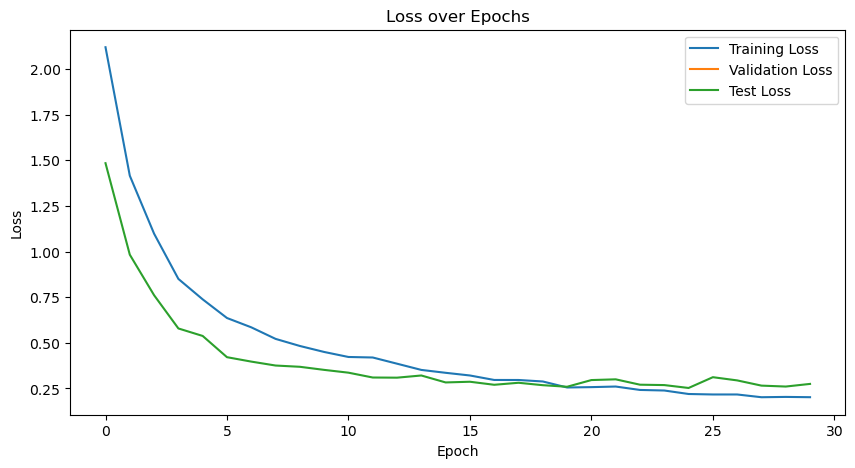

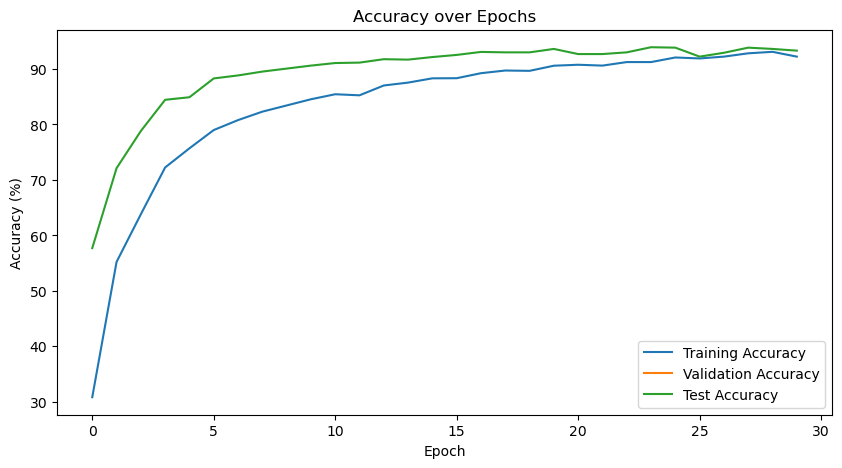

In [31]:
import matplotlib.pyplot as plt

# Plot training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training, validation, and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


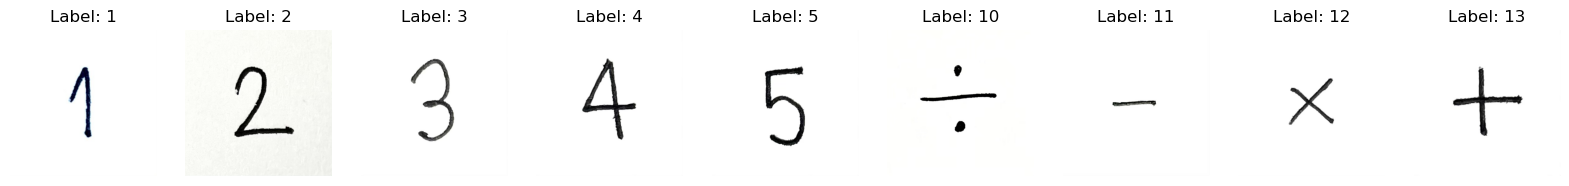

Recognized Digit: 1
Label: 1
Correct!
---------------------------
Recognized Digit: 2
Label: 2
Correct!
---------------------------
Recognized Digit: 3
Label: 3
Correct!
---------------------------
Recognized Digit: 4
Label: 4
Correct!
---------------------------
Recognized Digit: 5
Label: 5
Correct!
---------------------------
Recognized Digit: 10
Label: 10
Correct!
---------------------------
Recognized Digit: 11
Label: 11
Correct!
---------------------------
Recognized Digit: 12
Label: 12
Correct!
---------------------------
Recognized Digit: 13
Label: 13
Correct!
---------------------------


In [35]:
from PIL import Image
# Load an image from file

test_data = {
    1 : '/Users/dre/Dev/visi-solve/visi-solve/test_data/1.png',
    2 : '/Users/dre/Dev/visi-solve/visi-solve/test_data/2.png',
    3 : '/Users/dre/Dev/visi-solve/visi-solve/test_data/3.png',
    4 : '/Users/dre/Dev/visi-solve/visi-solve/test_data/4.png',
    5 : '/Users/dre/Dev/visi-solve/visi-solve/test_data/5.png',
    10: '/Users/dre/Dev/visi-solve/visi-solve/test_data/10.png',
    11: '/Users/dre/Dev/visi-solve/visi-solve/test_data/11.png',
    12: '/Users/dre/Dev/visi-solve/visi-solve/test_data/12.png',
    13: '/Users/dre/Dev/visi-solve/visi-solve/test_data/13.png',
}


# Show images of test_data in a plot
fig = plt.figure(figsize=(20, 10))
for i, (label, image_path) in enumerate(test_data.items()):
    image = Image.open(image_path)
    ax = fig.add_subplot(1, 9, i+1)
    ax.axis('off')
    ax.set_title(f'Label: {label}')
    plt.imshow(image)
plt.show()

for label, image_path in test_data.items():
    # 3,4 do not work good
    image = Image.open(image_path)

    # Define a transform to normalize the data
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply the same transformations as your dataset
    transformed_image = transform(image)

    # Unsqueeze to add a batch dimension
    image_batch = transformed_image.unsqueeze(0).to(device)

    # Load the model
    loaded_model = torch.load('/Users/dre/Dev/visi-solve/visi-solve/cnn/CNN_full_model.pth')
    loaded_model.eval()  # Set it to evaluation mode

    # Get predictions from the model
    with torch.no_grad():
        outputs = loaded_model(image_batch)
        _, predicted = torch.max(outputs, 1)
        recognized_digit = predicted.item()

    print(f'Recognized Digit: {recognized_digit}')
    print(f'Label: {label}')

    if label == recognized_digit:
        print('Correct!')
    else:
        print('Incorrect!')
    print('---------------------------')